<a href="https://colab.research.google.com/github/hafezgh/music_classification/blob/main/Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Music Genre Classification - MLDL - A.Y. 2020/21 - Politecnico di Torino

# 1.Loading the dataset and pre-processing

In [1]:
from google.colab import drive
import torch
drive.mount('/content/drive/')
 
if (torch.cuda.is_available()):
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
 
print(f'Device is set to {DEVICE}')
 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Device is set to cuda


In [2]:
import os
import torchvision
import math
from sklearn.metrics import confusion_matrix
import itertools
import gzip, pickle
import copy
import sys
import time
from datetime import datetime
from sklearn.metrics import multilabel_confusion_matrix
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
seed = 2045 # The singularity is near!
def manual_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    from torch.backends import cudnn
    cudnn.deterministic = True #type: ignore
    cudnn.benchmark = False # type: ignore

### Hyperparameters
inp_shape = (128,128)
c=3                 # Channel
h = inp_shape[0]    # Frequency
w = inp_shape[1]    # Time
k=3
filters = [64, 128, 128, 128]
poolings = [(2,2), (4,2), (4,2), (4,2)]
dropout_rate = 0.1
batch_size = 16
gru_units=32
lr = 0.1
n_classes = 10
epochs = 1
hparams = {'batch_size': batch_size, 'c': c, 'h':h, 'w':w, 'k':k, 'filters': filters,\
               'poolings': poolings, 'dropout_rate':dropout_rate, 'gru_units': gru_units, 'lr': lr, 'epochs':epochs}

#path = './drive/MyDrive/Colab Notebooks/Data'
path = './drive/MyDrive/music_classification/Data'
data_dir = path
print(os.listdir(data_dir))
classes = os.listdir(data_dir+'/images_original')
print(classes)

['features_30_sec.csv', 'features_3_sec.csv', 'images_original', 'genres_original']
['reggae', 'classical', 'rock', 'disco', 'jazz', 'metal', 'blues', 'pop', 'country', 'hiphop']


In [3]:
import torchvision.transforms as transforms
trans_norm = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.0,0.0,0.0), (1,1,1)),
                            transforms.Resize(inp_shape)
                            ])
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Resize(inp_shape)
                            ])

In [4]:
dataset = ImageFolder(data_dir+'/images_original',transform=trans)

In [54]:
# img, label = dataset[0]
# print(img.shape, label)
# fig, ax = plt.subplots(figsize=(10,15))
# # print(img[:,53,53])
# # print(img[:,54:-42,54:-42][0])
# crop1 = 54
# crop2 = 42
# img = img[:, crop1:-crop2, crop1:-crop2]
# print(img.shape, label)
# img = torch.transpose(img,0,2)
# ax.axis('off')
# ax.imshow(torch.transpose(img,0,1))

In [6]:
print(len(dataset))

999


# 2. Train-Test Split

In [9]:
train_size = int(np.ceil(len(dataset)*0.8))
val_size = int(np.ceil(len(dataset)*0.1))
test_size = len(dataset) - train_size - val_size
print(train_size, val_size, test_size)
manual_seed(2045)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths = [train_size, val_size, test_size])
# indices = np.random.permutation(len(dataset))
# train_idx, val_idx, test_idx = indices[:train_size], indices[train_size:train_size+val_size], indices[train_size+val_size:]

num_workers = 2
pin_memory = True
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=hparams['batch_size'], num_workers=num_workers, pin_memory=pin_memory)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=True, batch_size=hparams['batch_size'], num_workers=num_workers, pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=hparams['batch_size'], num_workers=num_workers, pin_memory=pin_memory)

800 100 99


# 3. Visualization

In [10]:
def get_number_distribution(loader, classes):
  total_category_count = {classes[i] : 0 for i in range(len(classes))}
  for _, labels in loader:
    for label in labels:
        total_category_count[classes[label]] += 1
  cat_count = []
  for category in classes:
    print('%s : %d' % (category, total_category_count[category]))
    cat_count.append((category, total_category_count[category]))
  cat_count.sort(key=lambda x:x[1])
  cat_count.reverse()
  return cat_count

In [11]:
# print('Train Set Number Ditribution:')
# train_cat_count = get_number_distribution(train_loader, classes)

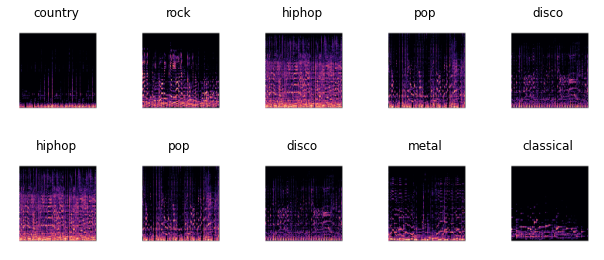

In [12]:
def imshow(img_array, labels, classes):
    figure, axs = plt.subplots(2, 5) 
    for i in range(2):
      for j in range(5):
        imgTmp = torch.transpose(img_array[i*2 + j],0,2)
        axs[i][j].imshow(torch.transpose(imgTmp, 0, 1))
        axs[i][j].set_title(classes[labels[i*2 + j]])
        axs[i][j].axis('off')
    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
    plt.show()

data_iter = iter(train_loader)
data_iter.next()
images, labels = data_iter.next()
distinct_labels = []
distinct_images = []
distinct_classes = []
for i in range(len(labels)):
  if classes[labels[i]] not in distinct_classes:
    distinct_labels.append(labels[i])
    distinct_images.append(images[i])
    distinct_classes.append(classes[labels[i]])
imshow(distinct_images[0:10], distinct_labels[0:10], classes)

# 4. Model

In [13]:
class CRNN(nn.Module):
    def __init__(self, class_num, c, h, w, k, filters, poolings, dropout_rate, gru_units=32):
        super(CRNN, self).__init__()
        input_shape = (c, h, w)

        # CNN
        self.bn0 = nn.BatchNorm2d(num_features=c)
        self.pad1 = nn.ZeroPad2d((int(k/2), int(k/2), int(k/2), int(k/2)))
        self.conv1 = nn.Conv2d(c, filters[0], kernel_size=k, stride=1)
        self.act1 = nn.ELU()
        self.bn1 = nn.BatchNorm2d(num_features=filters[0])
        self.maxPool1 = nn.MaxPool2d(kernel_size=poolings[0])
        self.drouput1 = nn.Dropout2d(dropout_rate)

        self.pad2 = nn.ZeroPad2d((int(k/2), int(k/2), int(k/2), int(k/2)))
        self.conv2 = nn.Conv2d(filters[0], filters[1], kernel_size=k)
        self.act2 = nn.ELU()
        self.bn2 = nn.BatchNorm2d(num_features=filters[1])
        self.maxPool2 = nn.MaxPool2d(kernel_size=poolings[1])
        self.drouput2 = nn.Dropout2d(dropout_rate)

        self.pad3 = nn.ZeroPad2d((int(k/2), int(k/2), int(k/2), int(k/2)))
        self.conv3 = nn.Conv2d(filters[1], filters[2], kernel_size=k)
        self.act3 = nn.ELU()
        self.bn3 = nn.BatchNorm2d(num_features=filters[2])
        self.maxPool3 = nn.MaxPool2d(kernel_size=poolings[2])
        self.drouput3 = nn.Dropout2d(dropout_rate)

        self.pad4 = nn.ZeroPad2d((int(k/2), int(k/2), int(k/2), int(k/2)))
        self.conv4 = nn.Conv2d(filters[2], filters[3], kernel_size=k)
        self.act4 = nn.ELU()
        self.bn4 = nn.BatchNorm2d(num_features=filters[3])
        self.maxPool4 = nn.MaxPool2d(kernel_size=poolings[3])
        self.drouput4 = nn.Dropout2d(dropout_rate)
        # Output is (m, chan, freq, time) -> Needs to be reshaped for feeding to GRU units
        # We will handle the reshape in the forward method

        # RNN
        self.gru1 = nn.GRU(input_size=128*1, hidden_size=32, batch_first=True)
        self.gru2 = nn.GRU(input_size=32 , hidden_size=32, batch_first=True)

        # Dense and softmax
        self.dense1 = nn.Linear(32, class_num)
        self.softm = nn.Softmax(dim=-1)
        
    def forward(self, x):
        # CNN forward
        x = self.bn0(x)
        x = self.pad1(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.bn1(x)
        x = self.maxPool1(x)
        x = self.drouput1(x)

        x = self.pad2(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.bn2(x)
        x = self.maxPool2(x)
        x = self.drouput2(x)

        x = self.pad3(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.bn3(x)
        x = self.maxPool3(x)
        x = self.drouput3(x)

        x = self.pad4(x)
        x = self.conv4(x)
        x = self.act4(x)
        x = self.bn4(x)
        x = self.maxPool4(x)
        x = self.drouput4(x)

        # Reshape
        x = x.permute(0,3,2,1)
        x = torch.reshape(x, (int(x.shape[0]), int(x.shape[1]), int(x.shape[2]*x.shape[3])))
        # RNN forward
        x = self.gru1(x)[0]
        x = self.gru2(x)[1][0]
        # Dense and softmax forward
        x = self.dense1(x)
        x = self.softm(x)
        return x

In [14]:
from torchsummary import summary
model = CRNN(len(classes), hparams['c'], hparams['h'], hparams['w'], hparams['k'], hparams['filters'],\
                      hparams['poolings'], hparams['dropout_rate'], gru_units=hparams['gru_units'])
model.to(DEVICE)
summary(model, (hparams['c'], hparams['h'], hparams['w']), batch_size=hparams['batch_size'])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [16, 3, 128, 128]               6
         ZeroPad2d-2          [16, 3, 130, 130]               0
            Conv2d-3         [16, 64, 128, 128]           1,792
               ELU-4         [16, 64, 128, 128]               0
       BatchNorm2d-5         [16, 64, 128, 128]             128
         MaxPool2d-6           [16, 64, 64, 64]               0
         Dropout2d-7           [16, 64, 64, 64]               0
         ZeroPad2d-8           [16, 64, 66, 66]               0
            Conv2d-9          [16, 128, 64, 64]          73,856
              ELU-10          [16, 128, 64, 64]               0
      BatchNorm2d-11          [16, 128, 64, 64]             256
        MaxPool2d-12          [16, 128, 16, 32]               0
        Dropout2d-13          [16, 128, 16, 32]               0
        ZeroPad2d-14          [16, 128,

# 5. Training

In [15]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            #print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('Early stopping activated!')
                self.early_stop = True

In [16]:
def fit(model, train_loader, train_len, optimizer, criterion):
    model.train()
    batch_size = train_loader.batch_size
    n_batches = math.ceil(train_len/batch_size)
    #print('Batch Size:', batch_size,'Number of Batches:', n_batches)
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    #prog_bar = tqdm(enumerate(train_loader), total=int(train_len/batch_size))
    for i, data in enumerate(train_loader):
        counter += 1
        data, target = data[0].to(DEVICE), data[1].to(DEVICE)
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

In [17]:
def validate(model, val_loader, val_len, criterion):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    batch_size = val_len
    #prog_bar = tqdm(enumerate(val_loader), total=int(val_len/batch_size))
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            counter += 1
            data, target = data[0].to(DEVICE), data[1].to(DEVICE)
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

In [22]:
def train(hparams, train_loader, val_loader, test_loader, train_len, val_len, test_len, **kwargs):
    manual_seed(2045)
    model = CRNN(len(classes), hparams['c'], hparams['h'], hparams['w'], hparams['k'], hparams['filters'],\
                    hparams['poolings'], hparams['dropout_rate'], gru_units=hparams['gru_units'])
    model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=hparams['lr'])
    try:
        path = kwargs['path']
        stream = gzip.open(path, "rb")
        checkpoint = pickle.load(stream)
        stream.close()
        train_loss = checkpoint['train_loss']
        train_accuracy = checkpoint['train_accuracy']
        val_loss = checkpoint['val_loss']
        val_accuracy = checkpoint['val_accuracy']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_load = checkpoint['epoch']
        print(f'Checkpoint found! Training will resume from epoch {epoch_load+1}')
        print('Last epoch results: ')
        print(f"Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_accuracy[-1]:.2f}")
        print(f'Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_accuracy[-1]:.2f}')
        if 'lr_scheduler' in kwargs.keys() and 'scheduler_state_dict' in checkpoint.keys():
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1, last_epoch=-1)
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    except:
        print('No checkpoints found! Training will start from the beginning.')
        train_loss, train_accuracy = [], []
        val_loss, val_accuracy = [], []
        epoch_load = 0
        scheduler = None
        es = False
        if 'lr_scheduler' in kwargs.keys():
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1, last_epoch=-1)

    es = False
    if 'early_stopping' in kwargs.keys():
        es = True
        min_val_loss = np.inf
        patience = 10
        epochs_no_improve = 0
        best_model = None

    criterion = nn.CrossEntropyLoss()

    start = time.time()
    for epoch in range(hparams['epochs']-epoch_load):
        print(f"Epoch {epoch+epoch_load+1} of {hparams['epochs']}")
        train_epoch_loss, train_epoch_accuracy = fit(
            model, train_loader, train_len, optimizer, criterion
        )
        val_epoch_loss, val_epoch_accuracy = validate(
            model, val_loader, val_len, criterion
        )
        if scheduler:
            scheduler.step()
        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)

        if es:
            if val_epoch_loss < min_val_loss:
                #Saving the model
                min_val_loss = val_epoch_loss
                best_model = copy.deepcopy(model.state_dict())
                #print('Min loss %0.2f' % min_loss)
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            # Check early stopping condition
            if epochs_no_improve == patience:
                print(f'Early stopping after {epoch+epoch_load+1} epochs!')
                model.load_state_dict(best_model)
                break
                
        print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
        print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
        checkpoint_to_save = {'model_state_dict': model.state_dict(),                                                 
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch+epoch_load,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_accuracy': train_accuracy,
                'val_accuracy': val_accuracy
                }
        if scheduler:
            checkpoint_to_save['scheduler_state_dict'] = scheduler.state_dict()
        stream = gzip.open('/content/drive/MyDrive/music_classification/checkpoint.pt', "wb")
        pickle.dump(checkpoint_to_save, stream)
        stream.close()
    end = time.time()

    print(f"Training time: {(end-start)/60:.3f} minutes")
    return model, train_loss, train_accuracy, val_loss, val_accuracy

In [26]:
hparams['epochs'] = 1000
hparams['lr'] = 0.001

In [27]:
model, train_loss, train_accuracy, val_loss, val_accuracy = train(hparams, train_loader, val_loader, test_loader, train_size, val_size,\
                                                                  test_size, lr_scheduler=False,\
                                                                  early_stopping=True,\
                                                                  path='/content/drive/MyDrive/music_classification/checkpoint.pt')

Checkpoint found! Training will resume from epoch 33
Last epoch results: 
Train Loss: 1.8852, Train Acc: 58.62
Val Loss: 1.9059, Val Acc: 57.00
Epoch 33 of 1000
Train Loss: 1.8704, Train Acc: 60.25
Val Loss: 1.8956, Val Acc: 60.00
Epoch 34 of 1000
Train Loss: 1.8641, Train Acc: 60.88
Val Loss: 1.9079, Val Acc: 58.00
Epoch 35 of 1000
Train Loss: 1.8804, Train Acc: 59.25
Val Loss: 1.8758, Val Acc: 57.00
Epoch 36 of 1000
Train Loss: 1.8766, Train Acc: 59.38
Val Loss: 1.9086, Val Acc: 56.00
Epoch 37 of 1000
Train Loss: 1.8728, Train Acc: 60.00
Val Loss: 1.9200, Val Acc: 54.00
Epoch 38 of 1000
Train Loss: 1.8602, Train Acc: 60.88
Val Loss: 1.9140, Val Acc: 54.00
Epoch 39 of 1000
Train Loss: 1.8739, Train Acc: 59.62
Val Loss: 1.8737, Val Acc: 56.00
Epoch 40 of 1000
Train Loss: 1.8561, Train Acc: 61.38
Val Loss: 1.9338, Val Acc: 56.00
Epoch 41 of 1000
Train Loss: 1.8613, Train Acc: 60.88
Val Loss: 1.8798, Val Acc: 56.00
Epoch 42 of 1000
Train Loss: 1.8556, Train Acc: 61.00
Val Loss: 1.8666, V

# 6. Post-processing

In [28]:
manual_seed(2045)
model = CRNN(len(classes), hparams['c'], hparams['h'], hparams['w'], hparams['k'], hparams['filters'],\
                hparams['poolings'], hparams['dropout_rate'], gru_units=hparams['gru_units'])
model.to(DEVICE)
path = '/content/drive/MyDrive/music_classification/checkpoint.pt'
stream = gzip.open(path, "rb")
checkpoint = pickle.load(stream)
stream.close()
train_loss = checkpoint['train_loss']
train_accuracy = checkpoint['train_accuracy']
val_loss = checkpoint['val_loss']
val_accuracy = checkpoint['val_accuracy']
model.load_state_dict(checkpoint['model_state_dict'])
epoch_load = checkpoint['epoch']
print(f'Model loaded! Model has been trained for {epoch_load+1} epochs.')
print('Last epoch results: ')
print(f"Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_accuracy[-1]:.2f}")
print(f'Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_accuracy[-1]:.2f}')

Model loaded! Model has been trained for 54 epochs.
Last epoch results: 
Train Loss: 1.8644, Train Acc: 60.62
Val Loss: 1.8804, Val Acc: 59.00


In [29]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)




    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()

In [30]:
def detailed_analysis(model, n_classes, class_names, train_loader, val_loader, test_loader, val_accuracy, train_accuracy, val_loss, train_loss):
    model.eval()

    ### Train
    loader = train_loader
    correct = 0.
    total = 0.
    class_corrects = [0.] * n_classes
    class_totals = [0.] * n_classes
    class_accs_train = [0.] * n_classes
    y_true = []
    y_pred = []
    with torch.no_grad():
      for images, labels in loader:
        outputs = model(images.to(DEVICE))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()
        Bool = (predicted.to('cpu') == labels)
        y_pred.extend(list(predicted.to('cpu').numpy()))
        y_true.extend(list(labels.numpy()))
        for i in range(len(images)):
            class_totals[labels[i]] += 1
            if Bool[i] == True:
              class_corrects[labels[i]] += 1
    for i in range(n_classes):
      class_accs_train[i] = class_corrects[i]/class_totals[i]

    cm_train = confusion_matrix(y_true, y_pred)
    

    ### Val
    loader = test_loader
    correct = 0.
    total = 0.
    class_corrects = [0.] * n_classes
    class_totals = [0.] * n_classes
    class_accs_val = [0.] * n_classes
    y_true = []
    y_pred = []
    with torch.no_grad():
      for images, labels in loader:
        outputs = model(images.to(DEVICE))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()
        Bool = (predicted.to('cpu') == labels)
        y_pred.extend(list(predicted.to('cpu').numpy()))
        y_true.extend(list(labels.numpy()))
        for i in range(len(images)):
            class_totals[labels[i]] += 1
            if Bool[i] == True:
              class_corrects[labels[i]] += 1
    for i in range(n_classes):
      class_accs_val[i] = class_corrects[i]/class_totals[i]
    cm_val = confusion_matrix(y_true, y_pred)


    ### Test
    loader = test_loader
    correct = 0.
    total = 0.
    class_corrects = [0.] * n_classes
    class_totals = [0.] * n_classes
    class_accs_test = [0.] * n_classes
    y_true = []
    y_pred = []
    with torch.no_grad():
      for images, labels in loader:
        outputs = model(images.to(DEVICE))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()
        Bool = (predicted.to('cpu') == labels)
        y_pred.extend(list(predicted.to('cpu').numpy()))
        y_true.extend(list(labels.numpy()))
        for i in range(len(images)):
            class_totals[labels[i]] += 1
            if Bool[i] == True:
              class_corrects[labels[i]] += 1
    for i in range(n_classes):
      class_accs_test[i] = class_corrects[i]/class_totals[i]
    cm_test = confusion_matrix(y_true, y_pred)

    fig, axs = plt.subplots(3, figsize=(30,20))
    axs[0].plot(list(range(1,len(train_loss)+1)), train_loss, label='Train Loss')
    axs[0].plot(list(range(1,len(train_loss)+1)), val_loss, label='Val Loss')
    axs[0].set_title('Loss per Epoch')
    axs[0].set_ylabel('Epoch')
    axs[0].set_xlabel('Loss')
    axs[0].legend()

    axs[1].plot(list(range(1,len(train_accuracy)+1)), train_accuracy, label='Train Acc')
    axs[1].plot(list(range(1,len(train_accuracy)+1)), val_accuracy, label='Val Acc')
    axs[1].set_title('Acc per Epoch')
    axs[1].set_ylabel('Epoch')
    axs[1].set_xlabel('Acc')
    axs[1].legend()

    x = np.arange(len(class_names))
    width = 0.3
    trains = axs[2].bar(x - width, class_accs_train, width, label='Train')
    vals = axs[2].bar(x, class_accs_val, width, label = 'Val')
    tests = axs[2].bar(x + width, class_accs_test, width, label = 'Test')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_title('Accuracy of Each Class')
    axs[2].set_xticks(x)
    axs[2].set_xticklabels(class_names)
    axs[2].legend()
    plt.show()

    return cm_train, cm_val, cm_test

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback

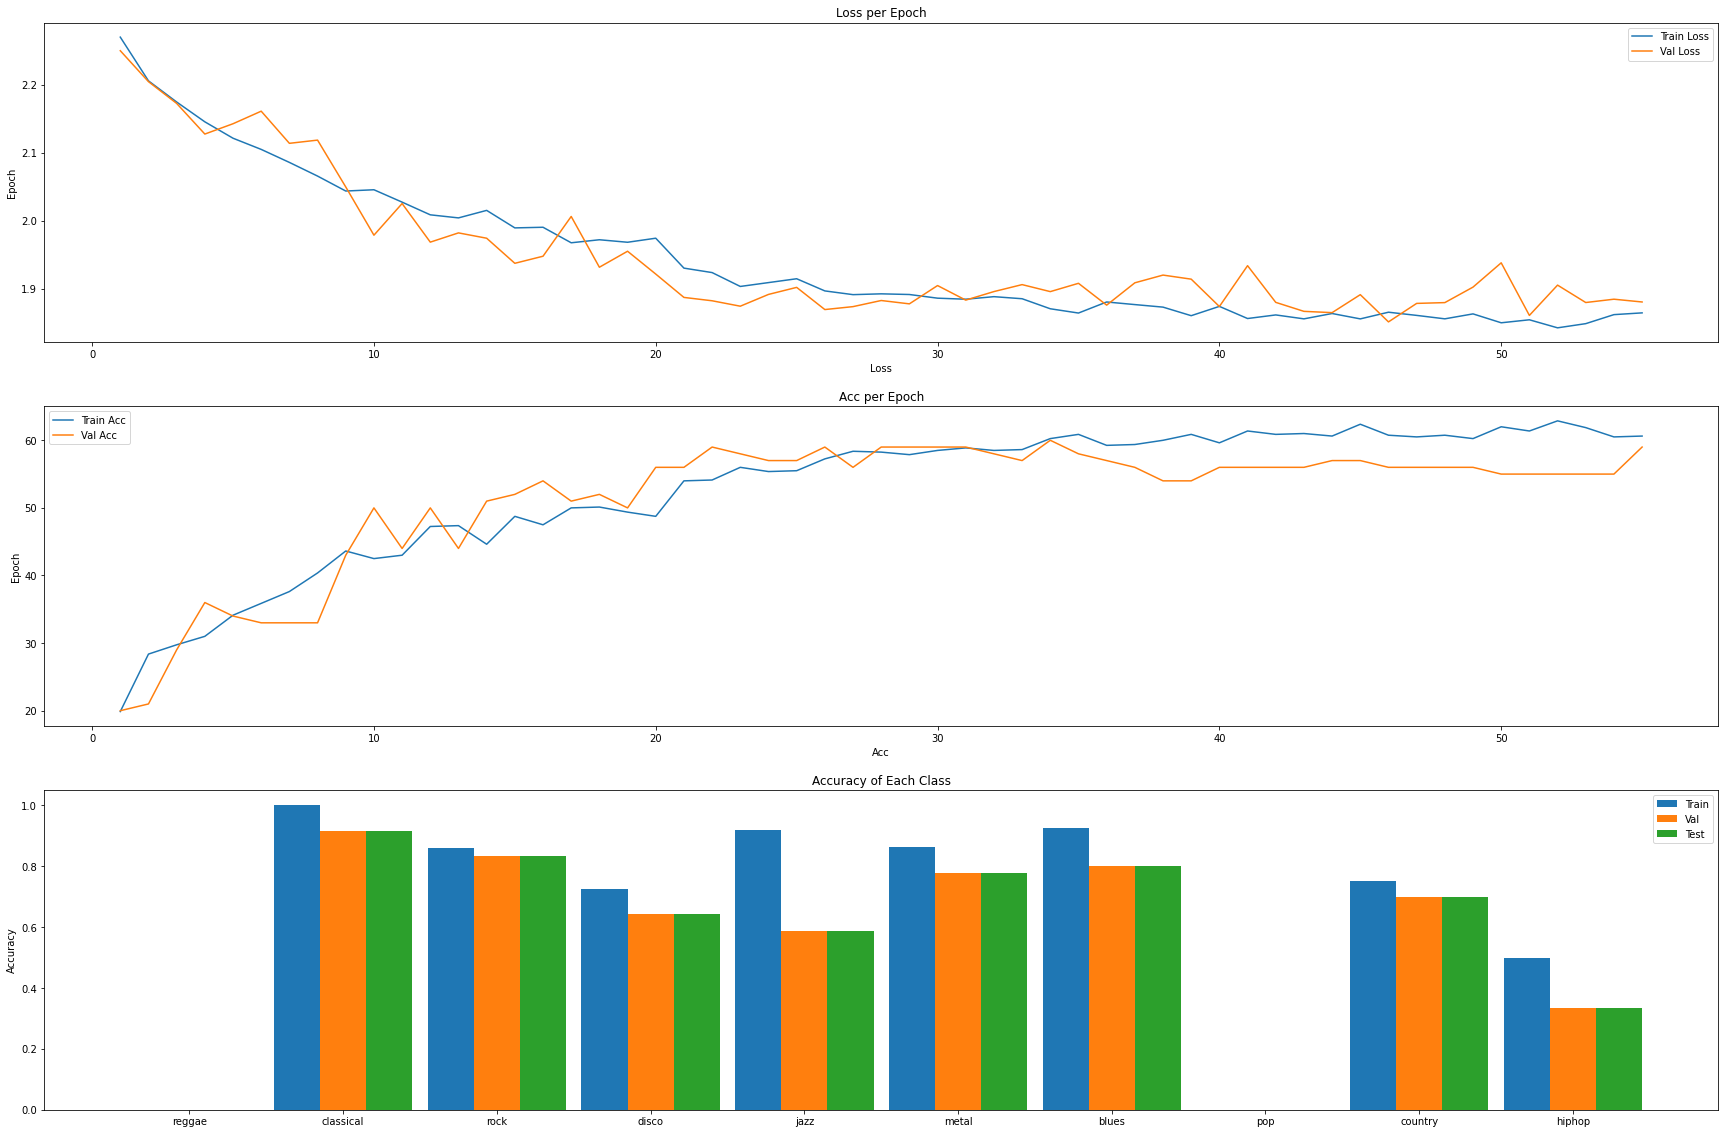

In [31]:
cm_train, cm_val, cm_test = class_accs_train, class_accs_val, class_accs_test = detailed_analysis(model, n_classes, classes,\
                                                                      train_loader, val_loader, test_loader,\
                                                                      val_accuracy, train_accuracy, val_loss, train_loss)

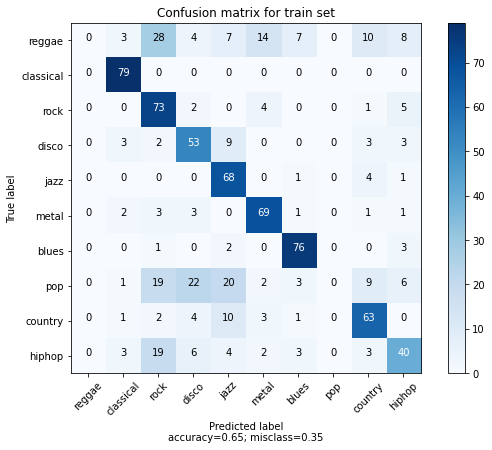

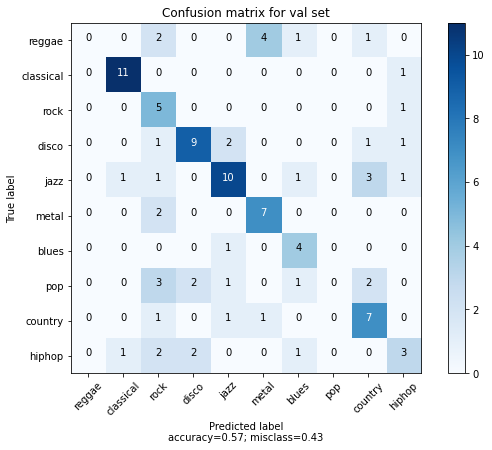

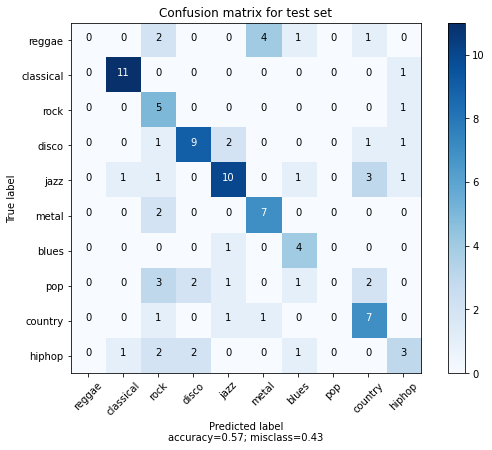

In [32]:
plot_confusion_matrix(cm_train, classes, title='Confusion matrix for train set', normalize=False)
print()
plot_confusion_matrix(cm_val, classes, title='Confusion matrix for val set', normalize=False)
print()
plot_confusion_matrix(cm_test, classes, title='Confusion matrix for test set', normalize=False)

# Appendix A. SVM Baseline

In [34]:
import pandas as pd
features3 = pd.read_csv('./drive/My Drive/music_classification/Data/features_3_sec.csv')
features30 = pd.read_csv('./drive/My Drive/music_classification/Data/features_30_sec.csv')

In [36]:
# features3.isnull().sum()

In [37]:
features3.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [38]:
labels3 = features3['label']
labels30 = features30['label']
features3 = features3.drop(['label', 'filename', 'length'],axis=1)
features30 = features30.drop(['label', 'filename', 'length'],axis=1)

In [48]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
msk = np.random.rand(len(features3)) < 0.8
X_train3 = features3[msk]
X_test3 = features3[~msk]
y_train3 = labels3[msk]
y_test3 = labels3[~msk]
clf3 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf3.fit(X_train3, y_train3)
y_pred3 = clf.predict(X_test3)

msk = np.random.rand(len(features30)) < 0.8
X_train30 = features30[msk]
X_test30 = features30[~msk]
y_train30 = labels30[msk]
y_test30 = labels30[~msk]
clf30 = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf30.fit(X_train30, y_train30)
y_pred30 = clf.predict(X_test30)

In [50]:
class_labels = list(clf3.classes_)

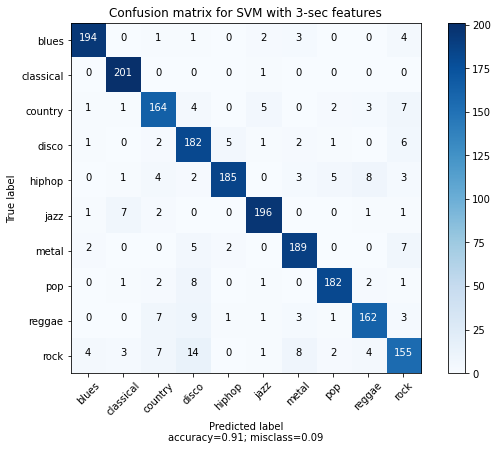

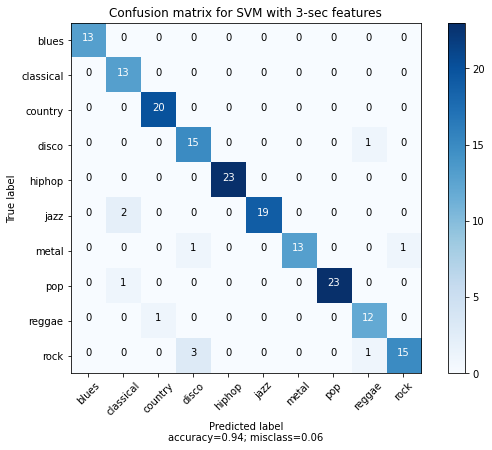

In [53]:
cm3 = confusion_matrix(y_test3, y_pred3)
plot_confusion_matrix(cm3, class_labels, title='Confusion matrix for SVM with 3-sec features', normalize=False)
print()
cm30 = confusion_matrix(y_test30, y_pred30)
plot_confusion_matrix(cm30, class_labels, title='Confusion matrix for SVM with 3-sec features', normalize=False)

# Francesco

In [ ]:
def split_indices(n, val_pct, seed):
  #Val set size
  n_val = int(val_pct*n)
  #set random seed
  np.random.seed(seed)
  #Create random perm
  idxs = np.random.permutation(n)
  return idxs[n_val:], idxs[:n_val]

In [ ]:
val_pct = 0.2
rand_seed = 42
train_indices, val_indices = split_indices(len(dataset),val_pct,rand_seed)
print(len(train_indices),len(val_indices))


NameError: ignored

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
batch_size = 16


In [ ]:
train_sampler =SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,batch_size,sampler=train_sampler)

In [ ]:
valid_sampler =SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,batch_size,sampler=valid_sampler)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
for images, labels in train_dl:
  print('images.shape:',images.shape) #from image
  
  
  break

In [ ]:
from torchsummary import summary
#model=CRNN()
#summary(model.cnn,(3, 288, 432),batch_size=16)

In [ ]:
class CRNN(nn.Module):
    def __init__(self):
        super(CRNN,self).__init__()

        self.cnn = nn.Sequential(
            nn.BatchNorm2d(num_features=3),

            nn.Conv2d(3,64,kernel_size=3, padding=1,stride=1),
            nn.ELU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.1),

            nn.Conv2d(64,128,kernel_size=3, padding=1,stride=1),
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(4,2)),
            nn.Dropout2d(0.1),

            nn.Conv2d(128,128,kernel_size=3, padding=1,stride=1),
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(4,2)),
            nn.Dropout2d(0.1),

            nn.Conv2d(128,128,kernel_size=3, padding=1,stride=1),
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(4,2)),
            nn.Dropout2d(0.1),
            
        )

        self.rnn = nn.Sequential(
            nn.GRU(input_size=6912,hidden_size=32,num_layers=2),
            nn.Dropout2d(0.3),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            
            nn.Linear(in_features=32,out_features=10),
            nn.Softmax2d()
        )

        return
        

    def forward(self, data):

        cnn_output     = self.cnn(data)
        print(cnn_output.size())
        #cnn_output     = cnn_output.squeeze(2)
        #print(cnn_output.size())
        #permute_output = cnn_output.permute(1,0,2)
        rnn_output     = self.rnn(cnn_output)
        print(rnn_output.size())
        output         = self.classifier(rnn_output)
        return output

    


    
    











# Confusion Mat

In [ ]:
#WHERE TO COMPUTE IT? (ONLY TEST SET)

#FIRST OPTION 
#def model_accuracy(model, n_classes, loader):
    #[...] nothing changes here
    #return accuracy, class_accs, output

#train_acc, train_class_accs, _ = model_accuracy(model, n_classes, train_loader)
#test_acc, test_class_accs, test_output = model_accuracy(model,n_classes, test_loader)
#print('Train Set Accuracy: {}%'.format(train_acc))
#print('Test Set Accuracy: {}%'.format(test_acc))
#confusion_matrix(test_loader, output)

#SECOND OPTION: 
#def model_accuracy(model, n_classes, loader, cm):
    #[...] nothing changes here
    #if cm == True : confusion_matrix(loader, outputs)
    #return accuracy, class_accs
  
#train_acc, train_class_accs, _ = model_accuracy(model, n_classes, train_loader, False)
#test_acc, test_class_accs, test_output = model_accuracy(model,n_classes, test_loader, True)
#print('Train Set Accuracy: {}%'.format(train_acc))
#print('Test Set Accuracy: {}%'.format(test_acc))
 

def confusion_matrix(loader, outputs):
        _, predicted = torch.max(outputs.data, 1)
        images, labels = next(iter(loader)) #since only one batch for the test set
  
        stacked= torch.stack(
            (
                labels, 
                predicted 
            ),
            dim=1
        ) #returns a stack in the form [label, prediction]

        cmt = torch.zeros(10, 10, dtype=torch.int32) 

        for p in stacked:
            true, predicted = p.tolist() 
            cmt[true, predicted]= cmt[true, predicted]+1
        
        print(cmt)
        #check for a better plotting function 
